In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
df = pd.read_csv('lin-reg-data.csv', index_col = 0)
df.tail()

,x1,x2,y
995,-0.942094,-0.835856,-22.324428
996,1.222445,-0.403177,-52.121493
997,-0.112466,-1.688230,-57.043196
998,-0.403459,-0.412272,-27.701833
999,0.021351,-0.499017,-9.804714


In [35]:
X = torch.tensor(df[['x1','x2']].values, dtype = torch.float)
y = torch.tensor(df['y'].values,dtype = torch.float)

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[:percent80], X[percent80:]
y_train, y_test = y[:percent80], y[percent80:]

mu, std = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std

In [36]:
class LinearRegression():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features,1, dtype = torch.float)
        self.bias = torch.zeros(1, dtype = torch.float)
        
    def forward(self, X):
        net_input = torch.add(torch.mm(X, self.weights), self.bias)
        activations = net_input
        return activations.view(-1)
    
    def backward(self, X, yhat, y):
        grad_loss_outer = 2 * (yhat - y)
        
        grad_weight_inner = X
        grad_bias_inner = 1
        
        grad_loss_weights = torch.mm(grad_weight_inner.t(),grad_loss_outer.view(-1,1)) / y.size(0)
        grad_loss_bias = torch.sum(grad_loss_outer) / y.size(0)
        
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

In [37]:
def loss(yhat, y):
    return torch.mean((yhat-y)**2)

def train(model, X, y, epochs, learning_rate):
    cost = []
    for i in range(epochs):
        torch.manual_seed(123)
        shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)

        X, y = X[shuffle_idx], y[shuffle_idx]
        yhat = model.forward(X)
        
        neg_grad_weights, neg_grad_bias = model.backward(X,yhat,y)
        model.weights += learning_rate*(neg_grad_weights)
        model.bias += learning_rate*(neg_grad_bias)
        
        yhat = model.forward(X) # Yhat after updating weights
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (i+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)
    return cost

In [38]:
model = LinearRegression(num_features = X_train.size(1))
cost = train(model, X_train,y_train, epochs = 100, learning_rate = 0.05)

Epoch: 001 | MSE: 1674.03052
Epoch: 002 | MSE: 1428.12463
Epoch: 003 | MSE: 1228.87891
Epoch: 004 | MSE: 1067.43958
Epoch: 005 | MSE: 936.63232
Epoch: 006 | MSE: 830.64484
Epoch: 007 | MSE: 744.76740
Epoch: 008 | MSE: 675.18420
Epoch: 009 | MSE: 618.80341
Epoch: 010 | MSE: 573.12000
Epoch: 011 | MSE: 536.10413
Epoch: 012 | MSE: 506.11136
Epoch: 013 | MSE: 481.80905
Epoch: 014 | MSE: 462.11749
Epoch: 015 | MSE: 446.16193
Epoch: 016 | MSE: 433.23340
Epoch: 017 | MSE: 422.75772
Epoch: 018 | MSE: 414.26944
Epoch: 019 | MSE: 407.39157
Epoch: 020 | MSE: 401.81845
Epoch: 021 | MSE: 397.30264
Epoch: 022 | MSE: 393.64352
Epoch: 023 | MSE: 390.67859
Epoch: 024 | MSE: 388.27609
Epoch: 025 | MSE: 386.32935
Epoch: 026 | MSE: 384.75192
Epoch: 027 | MSE: 383.47379
Epoch: 028 | MSE: 382.43802
Epoch: 029 | MSE: 381.59879
Epoch: 030 | MSE: 380.91876
Epoch: 031 | MSE: 380.36765
Epoch: 032 | MSE: 379.92114
Epoch: 033 | MSE: 379.55933
Epoch: 034 | MSE: 379.26617
Epoch: 035 | MSE: 379.02856
Epoch: 036 | MSE

<function matplotlib.pyplot.show(close=None, block=None)>

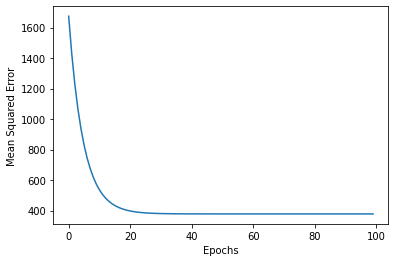

In [39]:
plt.plot(range(len(cost)),cost)
plt.ylabel("Mean Squared Error")
plt.xlabel("Epochs")
plt.show

In [40]:
train_pred = model.forward(X_train)
test_pred = model.forward(X_test)

print('Train MSE: %.5f' % loss(train_pred, y_train))
print('Test MSE: %.5f' % loss(test_pred, y_test))

Train MSE: 378.01355
Test MSE: 401.82919


In [41]:
print("Model Weights:",model.weights)
print("Model Bias", model.bias)

Model Weights: tensor([[ 0.6590],
        [39.9671]])
Model Bias tensor([-1.9991])


In [42]:
def analytical_sol(X,y):
    Xb = torch.cat((torch.ones((X.size(0), 1)), X), dim = 1)
    w = torch.zeros(X.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(X.size(1),1)
    return w, b

w, b = analytical_sol(X_train, y_train)
print("Analytical Weights:", w)
print("Analytical Bias", b)

Analytical Weights: tensor([[ 0.6591],
        [39.9682]])
Analytical Bias tensor([-1.9991])
